In [2]:
from datasets import load_dataset
import json, os, random
import dotenv
from huggingface_hub import login, hf_hub_download
# OPTIMIZED VERSION - Process subset for faster development
from tqdm import tqdm
import warnings
from collections import defaultdict

dotenv.load_dotenv()

HF_TOKEN = os.getenv("HUGGINGFACE_ACCESS_TOKEN")
login(token=HF_TOKEN)

OUTDIR = "direct_response"
os.makedirs(OUTDIR, exist_ok=True)
train_path = f"{OUTDIR}/train.jsonl"
val_path   = f"{OUTDIR}/val.jsonl"


/opt/anaconda3/envs/cs224n-cpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "socratesft/socrates-llama3-8b-sft"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

ModuleNotFoundError: No module named 'transformers'

In [4]:
prompt = "Your prompt here"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=100)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)


NameError: name 'tokenizer' is not defined

In [3]:
mapping_file = hf_hub_download(
    repo_id="socratesft/SocSci210",
    filename="metadata/participant_mapping.json",
    repo_type="dataset"
)

with open(mapping_file, 'r') as f:
    participant_mapping = json.load(f)


unseen_studies = set(participant_mapping['unseen'])

In [4]:
# Suppress the metadata warning (this is harmless - just missing README metadata)
warnings.filterwarnings("ignore", message="Repo card metadata block was not found")

dataset = load_dataset("socratesft/SocSci210", token=HF_TOKEN)

dataset = dataset["train"]
# Verify the dataset loaded successfully
print(f"✓ Dataset loaded: {len(dataset)} examples")
print(f"✓ Columns: {list(dataset.features.keys())}") 

Repo card metadata block was not found. Setting CardData to empty.


✓ Dataset loaded: 2901390 examples
✓ Columns: ['sample_id', 'participant', 'demographic', 'stimuli', 'response', 'condition_num', 'task_num', 'prompt', 'reasoning', 'study_id']


In [5]:
SYSTEM_TXT = "You are simulating a survey respondent. Answer exactly as instructed, following the specified response format without additional commentary."

def format_prompt(datapoint):
    prompt = datapoint['prompt']

    return {
        "messages": [
            {"role": "system", "content": SYSTEM_TXT},
            {"role": "user", "content": prompt}
        ]
    }



In [6]:

study_condition_groups = defaultdict(list)
study_condition_prompts = defaultdict(list)
study_condition_human_outcomes = defaultdict(list)

for datapoint in tqdm(dataset):
    if datapoint['study_id'] in unseen_studies:
        study_condition_groups[(datapoint['study_id'], datapoint['condition_num'])].append(datapoint)
        study_condition_prompts[(datapoint['study_id'], datapoint['condition_num'])].append(format_prompt(datapoint))
        study_condition_human_outcomes[(datapoint['study_id'], datapoint['condition_num'])].append(datapoint['response'])


100%|██████████| 2901390/2901390 [02:39<00:00, 18243.01it/s]


In [ ]:
# Run inference for all prompts
study_condition_results = defaultdict(list)

for key, prompts in tqdm(study_condition_prompts.items(), desc="Processing study conditions"):
    study_id, condition_num = key
    
    for prompt_data in tqdm(prompts, desc=f"Study {study_id}, Condition {condition_num}", leave=False):
        # Apply chat template to format messages properly for the model
        formatted_prompt = tokenizer.apply_chat_template(
            prompt_data['messages'],
            tokenize=False,
            add_generation_prompt=True
        )
        
        # Tokenize and move to device
        inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)
        
        # Generate response
        outputs = model.generate(
            **inputs,
            max_new_tokens=512,
            do_sample=False,  # Use greedy decoding for reproducibility
            pad_token_id=tokenizer.eos_token_id
        )
        
        # Decode only the generated tokens (exclude the prompt)
        generated_tokens = outputs[0][inputs['input_ids'].shape[1]:]
        response = tokenizer.decode(generated_tokens, skip_special_tokens=True)
        
        # Store result with the same key structure
        study_condition_results[key].append(response)

print(f"\n✓ Inference complete for {len(study_condition_results)} study-condition pairs")
print(f"✓ Total responses generated: {sum(len(v) for v in study_condition_results.values())}")


In [ ]:
# Inspect a sample of results
sample_key = list(study_condition_results.keys())[0]
print(f"Sample study-condition key: {sample_key}")
print(f"Number of responses: {len(study_condition_results[sample_key])}")
print(f"\nFirst response for this condition:")
print("-" * 80)
print(study_condition_results[sample_key][0])
print("-" * 80)


In [ ]:
def serialize_for_json(d):
    """Convert defaultdict with tuple keys to JSON-serializable format."""
    result = {}
    for (study_id, condition_num), value in d.items():
        # Create clean string key like "study_id_condition_num"
        key = f"{study_id}_{condition_num}"
        
        # Convert HuggingFace dataset items to plain dicts if needed
        if isinstance(value, list) and len(value) > 0:
            # Handle dataset items by converting to dict
            result[key] = [dict(item) if hasattr(item, 'keys') else item for item in value]
        else:
            result[key] = value
    return result

# Save study_condition_groups (raw datapoints)
print("Saving study_condition_groups...")
with open("direct_response/study_condition_groups.json", "w") as f:
    json.dump(serialize_for_json(study_condition_groups), f, indent=2)
print(f"✓ Saved {len(study_condition_groups)} study-condition groups")

# Save study_condition_prompts (formatted prompts)
print("Saving study_condition_prompts...")
with open("direct_response/study_condition_prompts.json", "w") as f:
    json.dump(serialize_for_json(study_condition_prompts), f, indent=2)
print(f"✓ Saved {len(study_condition_prompts)} study-condition prompts")

# Save study_condition_human_outcomes (human responses)
print("Saving study_condition_human_outcomes...")
with open("direct_response/study_condition_human_outcomes.json", "w") as f:
    json.dump(serialize_for_json(study_condition_human_outcomes), f, indent=2)
print(f"✓ Saved {len(study_condition_human_outcomes)} study-condition human outcomes")

# Save study_condition_results (model inference results)
print("Saving baseline_inference_results...")
with open("direct_response/baseline_inference_results.json", 'w') as f:
    json.dump(serialize_for_json(study_condition_results), f, indent=2)
print(f"✓ Saved {len(study_condition_results)} study-condition inference results")

print("\n✓ All data successfully saved!")



Saving study_condition_groups...
✓ Saved 194 study-condition groups
Saving study_condition_prompts...
✓ Saved 194 study-condition prompts
Saving study_condition_human_outcomes...
✓ Saved 194 study-condition human outcomes

✓ All data successfully saved!


In [12]:
study_condition_human_outcomes.keys()

dict_keys([('9nphm', 7), ('9nphm', 6), ('9nphm', 4), ('9nphm', 3), ('9nphm', 5), ('9nphm', 0), ('9nphm', 2), ('9nphm', 1), ('yjvpn', 5), ('yjvpn', 1), ('yjvpn', 0), ('yjvpn', 4), ('yjvpn', 3), ('yjvpn', 2), ('yp736', 1), ('yp736', 2), ('yp736', 0), ('3pcdm', 1), ('3pcdm', 0), ('3pcdm', 4), ('3pcdm', 3), ('3pcdm', 2), ('zsekp', 1), ('zsekp', 2), ('zsekp', 3), ('zsekp', 0), ('7jt2f', 6), ('7jt2f', 3), ('7jt2f', 1), ('7jt2f', 4), ('7jt2f', 5), ('7jt2f', 7), ('7jt2f', 2), ('7jt2f', 0), ('ztwqy', 1), ('ztwqy', 2), ('ztwqy', 0), ('ak35q', 1), ('ak35q', 7), ('ak35q', 3), ('ak35q', 4), ('ak35q', 6), ('ak35q', 0), ('ak35q', 2), ('ak35q', 5), ('ak35q', 8), ('a693y', 6), ('a693y', 3), ('a693y', 0), ('a693y', 7), ('a693y', 2), ('a693y', 5), ('a693y', 4), ('a693y', 1), ('xtvu5', 1), ('xtvu5', 0), ('a5v96', 1), ('a5v96', 5), ('a5v96', 4), ('a5v96', 3), ('a5v96', 2), ('a5v96', 0), ('a5v96', 6), ('rpw4u', 0), ('rpw4u', 1), ('ervm8', 0), ('ervm8', 1), ('ervm8', 2), ('b3ve6', 0), ('b3ve6', 1), ('b3ve6',

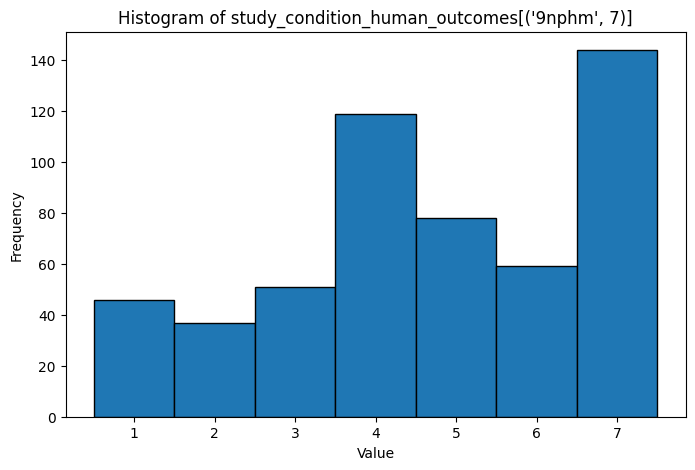

In [17]:
import matplotlib.pyplot as plt

# Get the numbers
numbers = study_condition_human_outcomes[('9nphm', 7)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(numbers, bins=range(min(numbers), max(numbers)+2), edgecolor='black', align='left')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title("Histogram of study_condition_human_outcomes[('9nphm', 7)]")
plt.xticks(range(min(numbers), max(numbers)+1))
plt.show()